# 2. Modelling

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

## 2.0. Uploaded (rescaled) preprocessed images/labels and renormalise them

In [14]:
# Load preprocessed training images and labels
train_input_dir = '../data/preprocessed/train'

train_images = []
train_labels = []

for i in range(120):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(train_input_dir, image_filename)
    image = cv2.imread(image_path)
    train_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(train_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    train_labels.append(label)

# Load preprocessed validation images and labels
val_input_dir = '../data/preprocessed/valid'

val_images = []
val_labels = []

for i in range(30):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(val_input_dir, image_filename)
    image = cv2.imread(image_path)
    val_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(val_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    val_labels.append(label)

# Load preprocessed test images
test_input_dir = '../data/preprocessed/test'

test_images = []

for i in range(5):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(test_input_dir, image_filename)
    image = cv2.imread(image_path)
    test_images.append(image)


In [15]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0

val_images = np.array(val_images) / 255.0
val_labels = np.array(val_labels) / 255.0

test_images = np.array(test_images) / 255.0

How big have we made our training set? 120
Some examples:


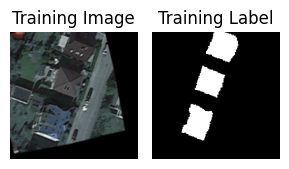

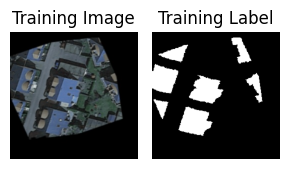

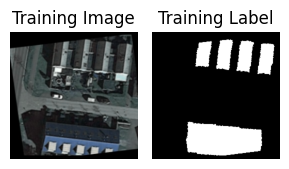

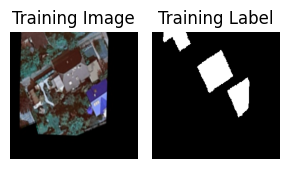

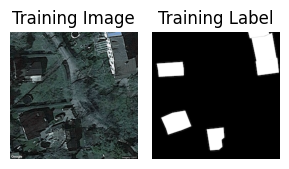

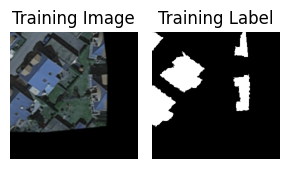

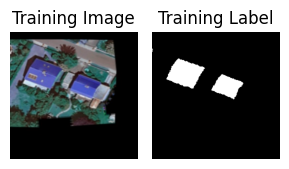

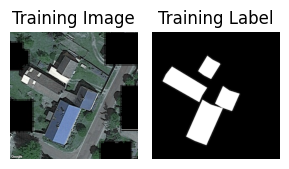

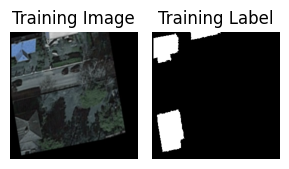

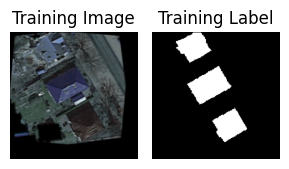

In [16]:
print(f"How big have we made our training set? {len(train_images)}")
print("Some examples:")

for index in range(len(train_images))[-10:]:

    plt.figure(figsize=(3,2))
    # Training image
    plt.subplot(1, 2, 1)
    plt.imshow(train_images[index])
    plt.title('Training Image')
    plt.axis('off')

    # Training label
    plt.subplot(1, 2, 2)
    plt.imshow(train_labels[index], cmap='gray')
    plt.title('Training Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 2.1 Network Architechture

We choose
Design a CNN architecture suitable for the image segmentation task. U-Net, SegNet, or Mask R-CNN are popular choices for such tasks. The network should take the input image as input and generate a binary mask where the roofs' boundaries are represented as white pixels (255) and the rest of the image as black (0).

U-Net is a popular choice due to its effectiveness in capturing spatial information. Below is an example implementation of the U-Net architecture:

In [17]:
from tensorflow.keras import layers

def unet():
    inputs = keras.Input(shape=(None, None, 3))

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    return keras.Model(inputs=inputs, outputs=outputs)


In [18]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_15 (Conv2D)             (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, None, None,   36928       ['conv2d_15[0][0]']              
                                64)                                                         

In [19]:
# Assuming you have loaded your training data into `train_images` and `train_masks` arrays
history = model.fit(train_images, train_labels, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
6/6 [==============================] - 132s 22s/step - loss: 0.5813 - accuracy: 0.7737 - val_loss: 0.5077 - val_accuracy: 0.8744
Epoch 2/10
6/6 [==============================] - 134s 22s/step - loss: 0.4525 - accuracy: 0.8832 - val_loss: 0.3834 - val_accuracy: 0.8744
Epoch 3/10
6/6 [==============================] - 130s 22s/step - loss: 0.3193 - accuracy: 0.8832 - val_loss: 0.3204 - val_accuracy: 0.8744
Epoch 4/10
6/6 [==============================] - 139s 24s/step - loss: 0.2998 - accuracy: 0.8832 - val_loss: 0.3072 - val_accuracy: 0.8744
Epoch 5/10
6/6 [==============================] - 130s 22s/step - loss: 0.2893 - accuracy: 0.8832 - val_loss: 0.2910 - val_accuracy: 0.8744
Epoch 6/10
6/6 [==============================] - 131s 22s/step - loss: 0.2716 - accuracy: 0.8832 - val_loss: 0.2803 - val_accuracy: 0.8744
Epoch 7/10


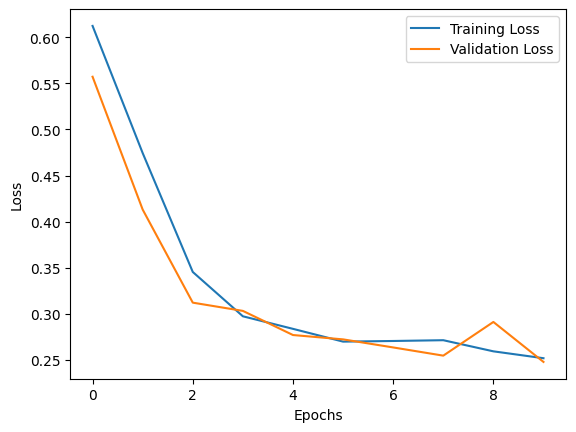

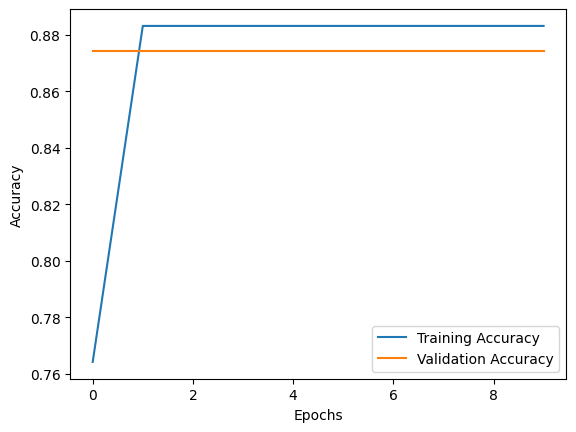

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curve
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Assuming you have loaded your validation data into `val_images` and `val_masks` arrays
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
# Assuming you have loaded your test data into `test_images` array
predictions = model.predict(test_images)

1/1 [==============================] - 11s 11s/step - loss: 0.2790 - accuracy: 0.8659
Validation Loss: 0.2790
Validation Accuracy: 0.8659
1/1 [==============================] - 2s 2s/step


In [ ]:
# Apply thresholding to convert predicted masks to binary images
def post_process(predictions, threshold=0.5):
    binary_images = (predictions > threshold).astype(np.uint8)
    return binary_images

processed_predictions = post_process(predictions, threshold=0.2)

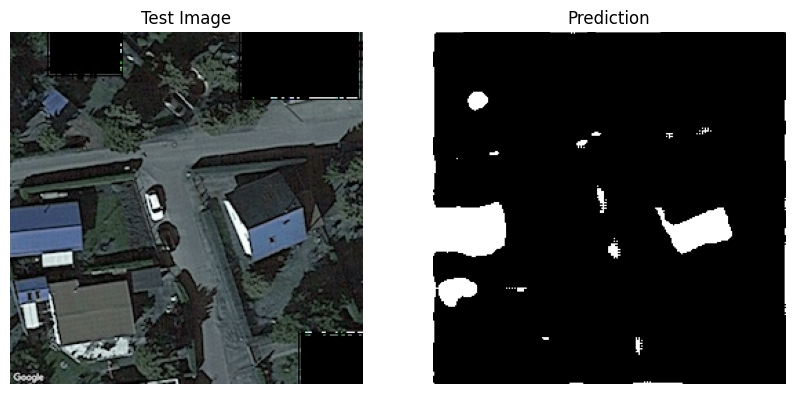

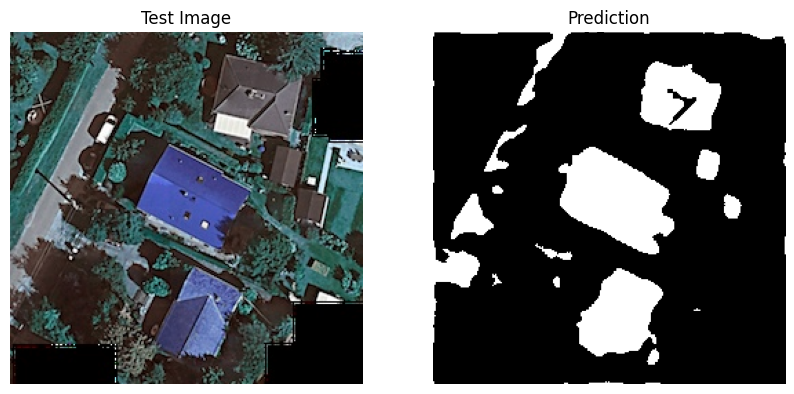

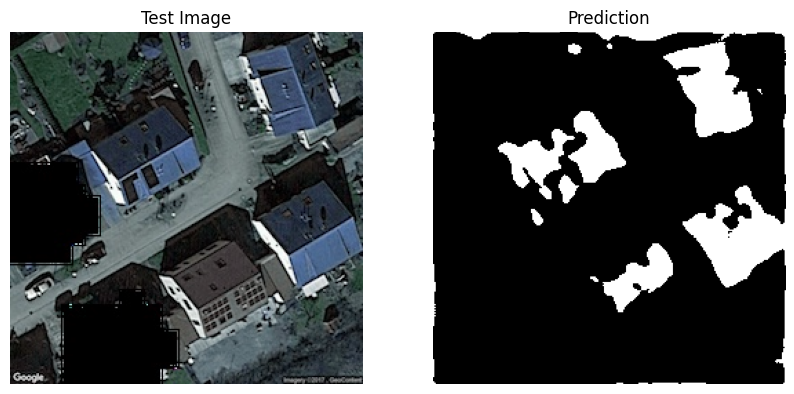

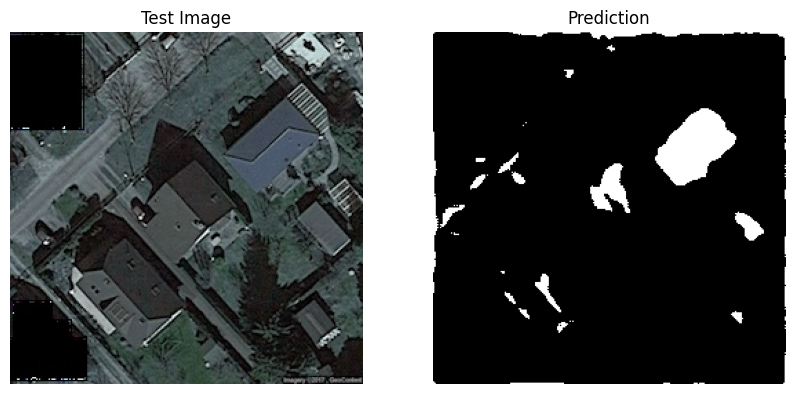

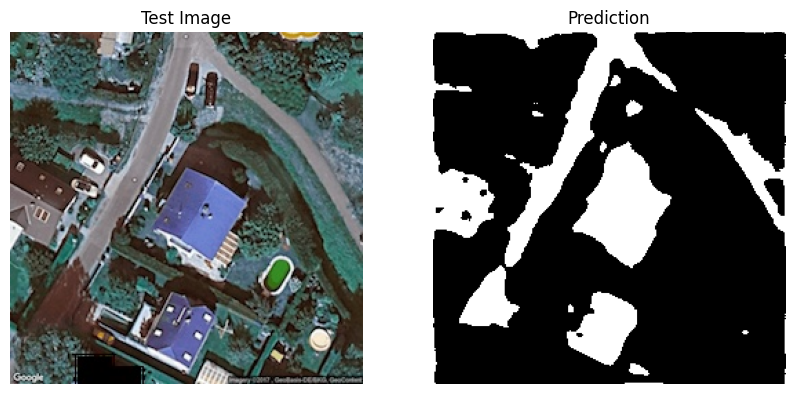

In [ ]:
# Assuming you have the same number of test images and predictions
for i in range(len(test_images)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display test image
    axes[0].imshow(test_images[i])
    axes[0].set_title('Test Image')
    axes[0].axis('off')
    
    # Display prediction
    axes[1].imshow(processed_predictions[i], cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')
    
    plt.show()

In [ ]:
# Save the entire model
model.save('../models/baseline.h5')

# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model("../models/baseline.h5")